# Datawrangling - Capstone 1
***

## Beer Review Data Description
***

The dataset we have contains over 1.5 million reviews of various beers from two websites: BeerAdvocate.com. This data not only includes user reviews, product category and alcohol by volume(ABV), but sensory aspects as well such as taste, look, smell and overall ratings. For this project we will train and test models to predict beer ratings and beer style based of the user reviews that were left.

These reviews were made available by Julian Mcauley, a UCSD Computer Science professor, from a collection period of January 1998 to November 2011. This dataset was accessed with permssion. Here are some key specs of the dataset itself.
+ Number of users: 33,387
+ Number of items: 66,051
+ Number of reviews: 1,586,259
    
To tackle the issue of size, we will take a subset sample of 99,999 reviews to train and test our models before applying it to the rest of the dataset.


### Import and Review Data
***

In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from textblob import TextBlob
from matplotlib import gridspec

In [2]:
beersmall = pd.read_excel('data/ratebeer_sample.xlsx')

In [3]:
beersmall.head()

,name,beerId,brewerId,ABV,style,appearance,aroma,palate,taste,overall,time,profileName,text
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4,6,3,6,13,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4,6,4,7,13,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,4,5,3,6,14,958694400,PhillyBeer2112,"Springfield, PA. I've never had the Budvar Cri..."
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,K•À_lsch,2,4,2,4,8,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,K•À_lsch,2,4,2,4,8,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."


In [4]:
beersmall.columns

Index(['name', 'beerId', 'brewerId', 'ABV', 'style', 'appearance', 'aroma',
       'palate', 'taste', 'overall', 'time', 'profileName', 'text'],
      dtype='object')

In [5]:
beersmall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 13 columns):
name           99999 non-null object
beerId         99999 non-null object
brewerId       99999 non-null int64
ABV            99999 non-null object
style          99999 non-null object
appearance     99999 non-null int64
aroma          99999 non-null int64
palate         99999 non-null int64
taste          99999 non-null int64
overall        99999 non-null int64
time           99999 non-null int64
profileName    99999 non-null object
text           99999 non-null object
dtypes: int64(7), object(6)
memory usage: 9.9+ MB


### Fix Spelling Errors

In [6]:
# Check for Beer Styles where the name needs to be altered.
beersmall['style'].unique()

array(['India Pale Ale &#40;IPA&#41;', 'Bohemian Pilsener', 'K•À_lsch',
       'Sweet Stout', 'Brown Ale', 'Belgian Ale', 'Abbey Tripel',
       'Belgian White &#40;Witbier&#41;', 'Mild Ale', 'Pale Lager',
       'Imperial/Double IPA', 'Sour Ale/Wild Ale', 'Traditional Ale',
       'Heller Bock', 'Porter', 'Bitter', 'Spice/Herb/Vegetable',
       'Imperial Stout', 'Belgian Strong Ale', 'Golden Ale/Blond Ale',
       'Scottish Ale', 'Stout', 'Scotch Ale', 'Abbey Dubbel', 'Saison',
       'Dunkel', 'American Pale Ale', 'Altbier', 'Wheat Ale',
       'Abt/Quadrupel', 'Oktoberfest/M•À_rzen', 'Baltic Porter',
       'Premium Lager', 'Imperial/Strong Porter', 'Smoked', 'Fruit Beer',
       'Amber Ale', 'English Pale Ale', 'Pilsener', 'German Hefeweizen',
       'Premium Bitter/ESB', 'Cream Ale', 'California Common', 'Vienna',
       'Barley Wine', 'Doppelbock', 'Sak•À_ - Ginjo',
       'American Strong Ale', 'Dunkler Bock', 'Black IPA',
       'Strong Pale Lager/Imperial Pils', 'Irish Ale', 

In [7]:
# Function to replace character errors in the style column
def replacestyle(col):
    # Replace each value that matches the left side of the pair
    return col.replace({
        'K•À_lsch': 'Kölsch',
        '&#40;' : '(',
        '&#41;' : ')',
        'M•À_rzen' : 'Märzen',
        'Sak•À_' : 'Sake',
        'Bi•À_re de Garde' : 'Bière de Garde'
    }, regex=True)

# Apply the function replacestyle to the beer['style'] column
beersmall['style'] = replacestyle(beersmall['style'])

# Function to replace character errors in the name column 
def replacename(col):
    # Replace each value that matches the left side of the pair
    return col.replace({
        '&quot;' : '"', 
        '&#40;' : '(',
        '&#41;' : ')',
        'Brï¿½u' : 'Bräu',
        'Kï¿½r' : 'Kür',
        'Mï¿½r' : 'Mär',
        'hï¿½f' : 'häf',
        'lï¿½n' : 'lán',
        'gï¿½u' : 'gäu',
        'rï¿½n' : 'rän',
        'tï¿½c' : 'tüc'
    }, regex= True)

# Apply the function replacename to the beer.name column
beersmall.name = replacename(beersmall.name)

## Examining and Cleaning the DataFrame 
***
Examining the first few columns of the dataframe you can notice a few things
+ Special characters and notation weren't read properly. We need to fix this somehow.
+ There is a time column that if we would want to use needs to be altered. In this case we don't need it, so we will drop it.
+ Beers have a range of reviews from 1 to x amount. We want beers to have at least 5 reviews so we need to remove the ones that have less
+ Some beers don't have an alcohol percentage (ABV)
+ Index needs to be redone.
+ The rating system is not on the same scale. "Aroma" and "Taste" ratings are on a scale of 10 while, the rest are on a scale of 5. 
***
### Extract a few distinct Beer Styles
Beer has many variations and the complexities of styles continues to grow as brewers blend styles from all around the world together. From looking at the data and the size of our sets there are 6 distinct styles of beers. The rest will be unecessary and a waste of space.
+ India Pale Ale (IPA)
+ Stout
+ German Hefeweizen
+ Amber Ale
+ Brown Ale
+ Belgian Ale


In [8]:
# Check to see how much data is available for each style.
beersmall['style'].value_counts()

India Pale Ale (IPA)       8138
American Strong Ale        6257
Belgian Strong Ale         5392
Amber Ale                  4452
Imperial/Double IPA        4271
Brown Ale                  4151
Abbey Tripel               4140
Stout                      4002
Abbey Dubbel               3695
American Pale Ale          3684
Barley Wine                3454
Imperial Stout             2982
Belgian Ale                2616
Porter                     2489
Pale Lager                 2483
Fruit Beer                 2307
Golden Ale/Blond Ale       2283
Pilsener                   1912
Bitter                     1785
Dortmunder/Helles          1778
German Hefeweizen          1654
Sweet Stout                1534
Spice/Herb/Vegetable       1465
Premium Bitter/ESB         1261
Belgian White (Witbier)    1129
Heller Bock                1063
Vienna                     1031
Oktoberfest/Märzen          976
Wheat Ale                   963
Cider                       886
                           ... 
English 

In [9]:
# Shrink the dataframe to contain only the style of beers desired
beersmall = beersmall.loc[beersmall['style'].isin(['India Pale Ale (IPA)', 'Stout','German Hefeweizen',
                                                   'Amber Ale', 'Brown Ale', 'Belgian Ale'])]

In [10]:
beers = ['India Pale Ale (IPA)', 'Stout', 'German Hefeweizen', 'Amber Ale', 'Brown Ale', 'Belgian Ale']

# For each beer print out the number of distinct beers and total number of reviews
print('Number of different beers for each style, Total number of reviews per style')
for b in beers:
    print(b, ': {}, {}'.format(len(beersmall[beersmall['style'] == b].name.value_counts()),
                                      len(beersmall[beersmall['style'] == b])))

Number of different beers for each style, Total number of reviews per style
India Pale Ale (IPA) : 231, 8138
Stout : 138, 4002
German Hefeweizen : 114, 1654
Amber Ale : 136, 4452
Brown Ale : 139, 4151
Belgian Ale : 90, 2616


### Adjust Rating Scales
***
In order to have all the ratings on the same scale, we will adjust the "aroma" and "taste" rating scales from a scale of 10 to a scale of 5. In addition, the "overall" scale appears to be representative of the other 4 rating values combined on a scale of 20. We will adjust this scale down to a scale of 5 as well.

In [11]:
beersmall['aroma'] = round(beersmall['aroma'] / 2).astype(int)
beersmall['taste'] = round(beersmall['taste'] / 2).astype(int)
beersmall['overall'] = (beersmall['appearance'] + beersmall['aroma'] + beersmall['palate'] + beersmall['taste']) / 4

In [12]:
beersmall.head()

,name,beerId,brewerId,ABV,style,appearance,aroma,palate,taste,overall,time,profileName,text
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4,3,3,3,3.25,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4,3,4,4,3.75,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....
6,John Harvards American Brown Ale,71714,8481,-,Brown Ale,4,2,3,3,3.00,1176076800,hopdog,"On tap at the Springfield, PA location. Listed..."
7,John Harvards Grand Cru,71719,8481,7,Belgian Ale,2,3,3,4,3.00,1107302400,JFGrind,"Sampled @ the Springfield, PA location. Cand..."
8,John Harvards Grand Cru,71719,8481,7,Belgian Ale,4,4,3,4,3.75,1102896000,egajdzis,Springfield... Poured a hazy copper color with...


### Break Down and Clean Text Reviews
*** 
Text reviews often times have spelling errors, extraneous words and punctuation that we may not need when analyzing the information. For this reason we are going to break down the reviews to deterimine the quality and quantity of them.

In [13]:
def avg_word_len(sentence):
    words = str(sentence).split()
    return (sum(len(word) for word in words)/len(words))

# Determine the word count for each text review: word_count
beersmall['word_count'] = beersmall['text'].apply(lambda x: len(str(x).split(" ")))

# Determine the character count for each text review: char_count
beersmall['char_count'] = beersmall['text'].str.len() ## this also includes spaces

# Determine the average word length per text review: avg_word_len
beersmall['avg_word_len'] = beersmall['text'].apply(lambda x: avg_word_len(x))

# Determine the number of stop words per text review: stop_words
stop = stopwords.words('english')
beersmall['stop_words'] = beersmall['text'].apply(lambda x: len([x for x in str(x).split() if x in stop]))

# Determine the number of uppercase words per text review: upper
beersmall['upper'] = beersmall['text'].apply(lambda x: len([x for x in str(x).split() if x.isupper()]))

beersmall[['text','word_count', 'char_count', 'avg_word_len', 'stop_words', 'upper']].head()

,text,word_count,char_count,avg_word_len,stop_words,upper
0,"On tap at the Springfield, PA location. Poured...",73,391,4.369863,28,3
1,On tap at the John Harvards in Springfield PA....,74,392,4.623188,26,3
6,"On tap at the Springfield, PA location. Listed...",90,486,4.400000,32,2
7,"Sampled @ the Springfield, PA location. Cand...",44,221,4.564103,15,2
8,Springfield... Poured a hazy copper color with...,59,344,5.296296,18,0


In [14]:
# Create a new column clean_text where each text review is cleaned to be prepared for sentiment analyses
# Change all characters in each review to lowercase.
beersmall['clean_text'] = beersmall['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

# Remove any special characters from each review.
beersmall['clean_text'] = beersmall['clean_text'].str.replace('[^\w\s]','')

# Remove any stop words.
beersmall['clean_text'] = beersmall['clean_text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

# Determine the 10 most frequent words and 10 least frequent words and remove them from each review
freq = pd.Series(' '.join(beersmall['clean_text']).split()).value_counts()[:10]
freq2 = pd.Series(' '.join(beersmall['clean_text']).split()).value_counts()[-10:]
beersmall['clean_text'] = beersmall['clean_text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
beersmall['clean_text'] = beersmall['clean_text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq2))

beersmall[['text', 'clean_text']].head()

,text,clean_text
0,"On tap at the Springfield, PA location. Poured...",tap springfield pa location poured deep cloudy...
1,On tap at the John Harvards in Springfield PA....,tap john harvards springfield pa pours ruby re...
6,"On tap at the Springfield, PA location. Listed...",tap springfield pa location listed menu james ...
7,"Sampled @ the Springfield, PA location. Cand...",sampled springfield pa location candi sugar do...
8,Springfield... Poured a hazy copper color with...,springfield poured hazy copper color medium si...


***

# Exploratory Data Analysis

In [15]:
def hist_rating_beer(col):
    
    for b in beers:
        sns.set()
        plt.figure(figsize=(30,5))

        plt.subplot(151)
        plt.hist(beersmall[beersmall['style'] == b].groupby(col).mean()['appearance'], range=[1, 5], 
                 color='darkred')
        plt.title('Appearance')
        plt.ylabel(b)
        plt.xlabel('Scale')

        plt.subplot(152)
        plt.hist(beersmall[beersmall['style'] == b].groupby(col).mean()['palate'], range=[1, 5], 
                 color='darkgreen')
        plt.title('Palate')
        plt.ylabel(b)
        plt.xlabel('Scale')

        plt.subplot(153)
        plt.hist(beersmall[beersmall['style'] == b].groupby(col).mean()['taste'], range=[1, 5], 
                 color='indigo')
        plt.title('Taste')
        plt.ylabel(b)
        plt.xlabel('Scale')

        plt.subplot(154)
        plt.hist(beersmall[beersmall['style'] == b].groupby(col).mean()['aroma'], 
                 color='goldenrod')
        plt.title('Aroma')
        plt.ylabel(b)
        plt.xlabel('Scale')

        plt.subplot(155)
        plt.hist(beersmall[beersmall['style'] == b].groupby(col).mean()['overall'], range=[1, 5], 
                 color='darkblue')
        plt.title('Overall')
        plt.ylabel(b)
        plt.xlabel('Scale')

        plt.tight_layout
        plt.suptitle('Reviews per Beer')
    plt.show()

def beer_counts(col, t):

    sns.set()

    plt.figure(figsize=(10,10))
    
    for i,b in enumerate(beers):
        
        plt.subplot(3,2,(i+1))
        
        review = beersmall[beersmall['style'] == b][col].value_counts()
        plt.boxplot(review)
        plt.title(b)
        
    plt.suptitle(t)
    plt.tight_layout()
    plt.show()

### Rating Scales
Lets begin our EDA by visualizing the number of ratings per category: appearance, taste, aroma, palate and overall. A bar graph was created for the 4 individual categories since they were chosen on a scale from 1 to 5. A histogram was chosen to represent the overall rating category because it represents an average of the other 4 categories. 


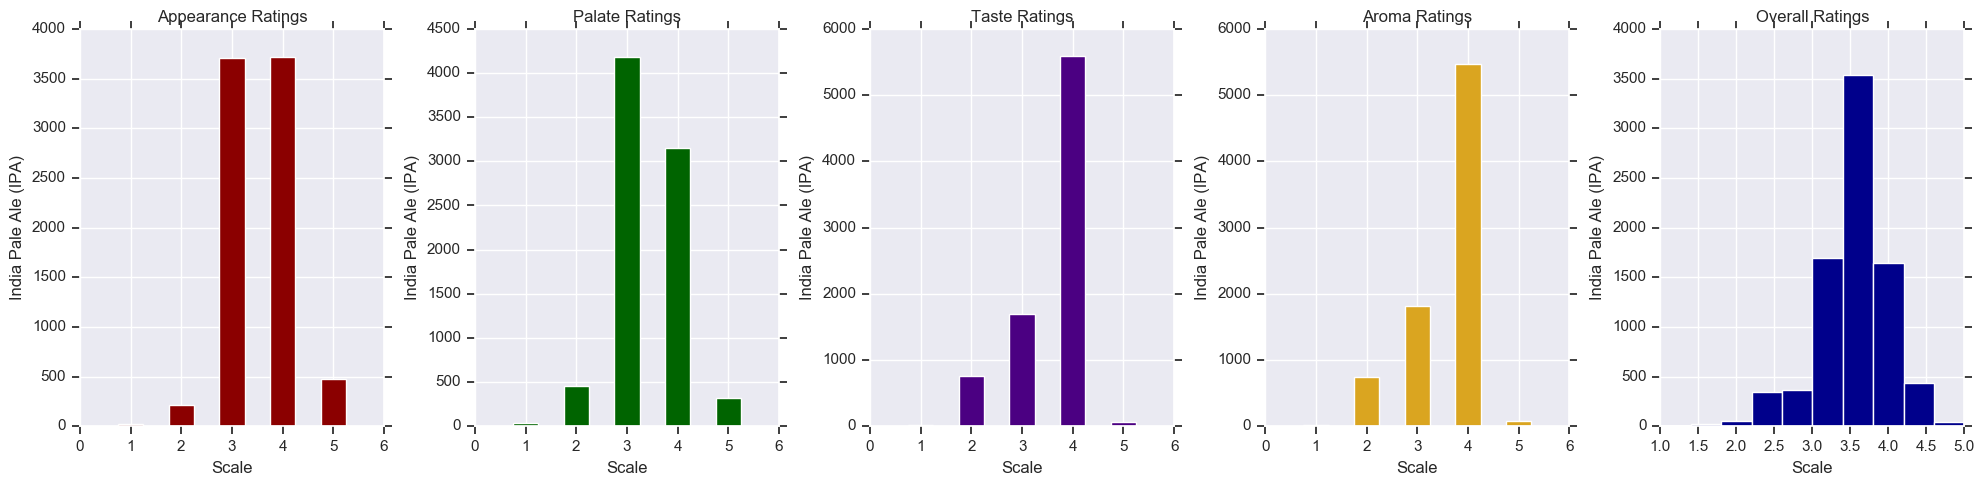

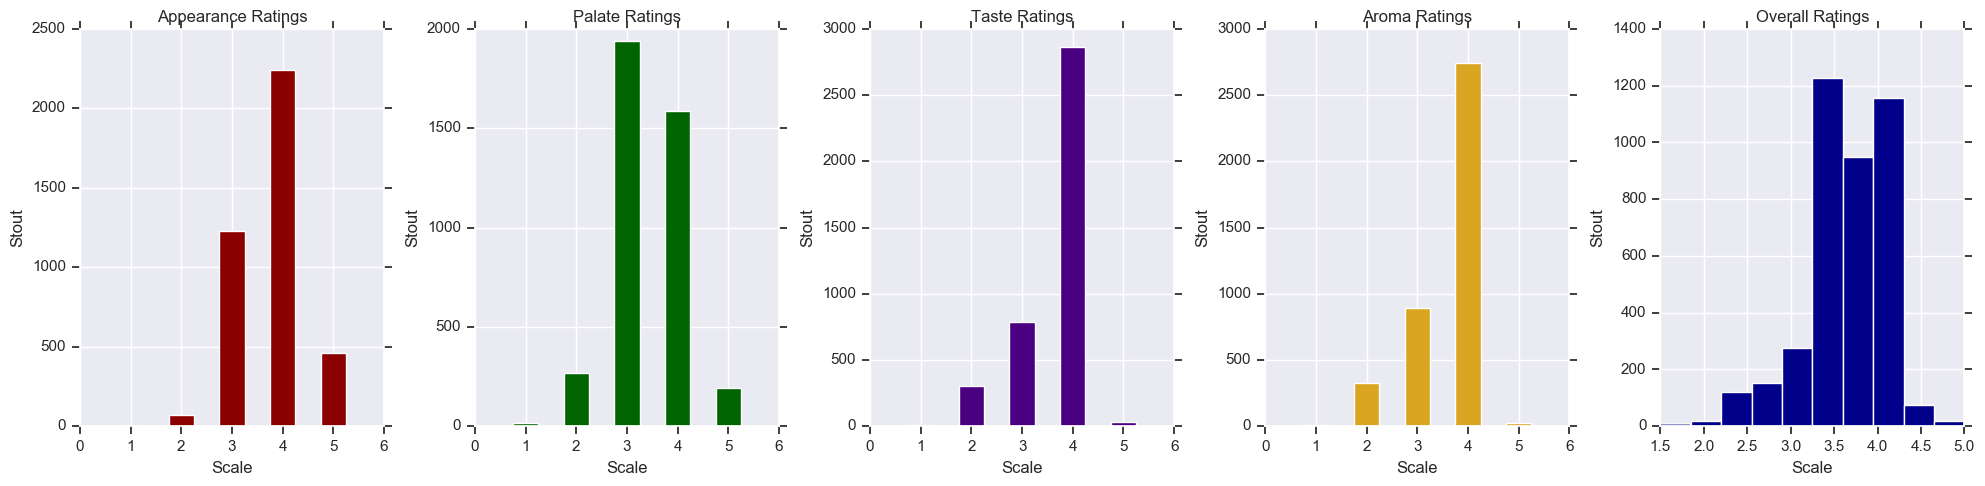

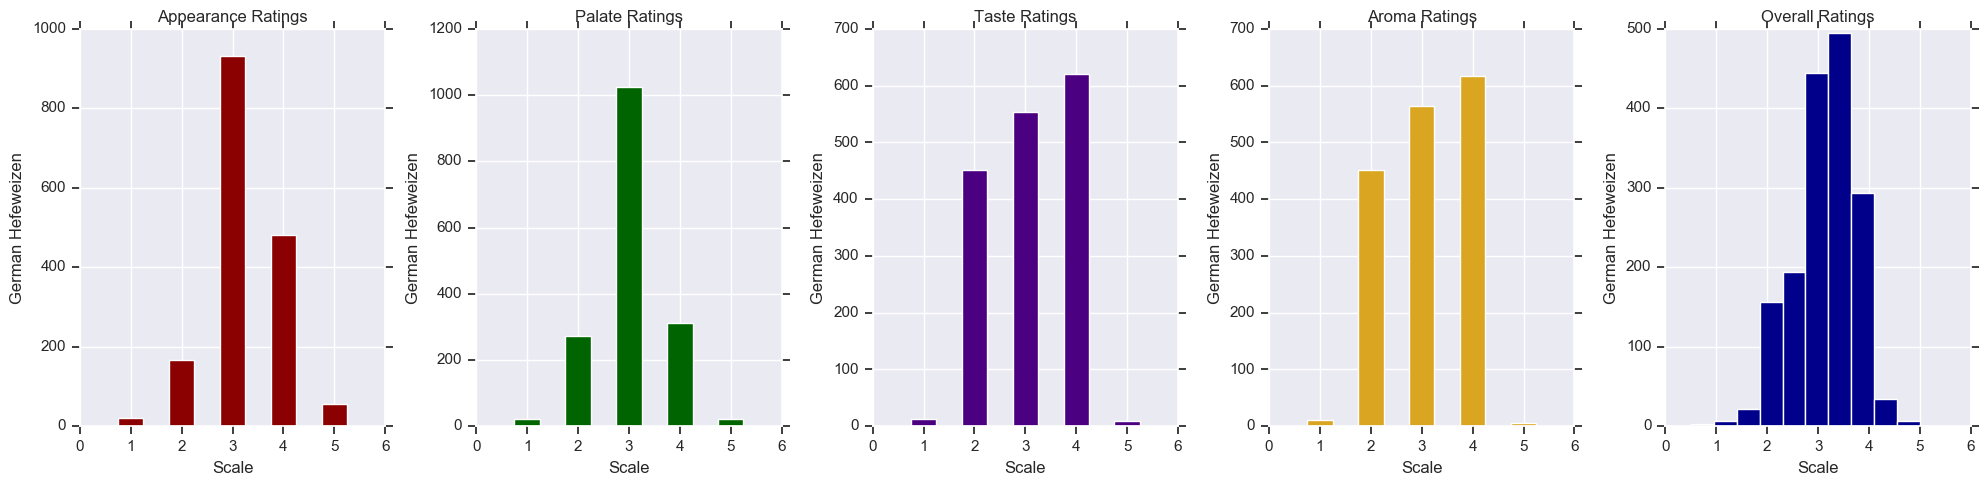

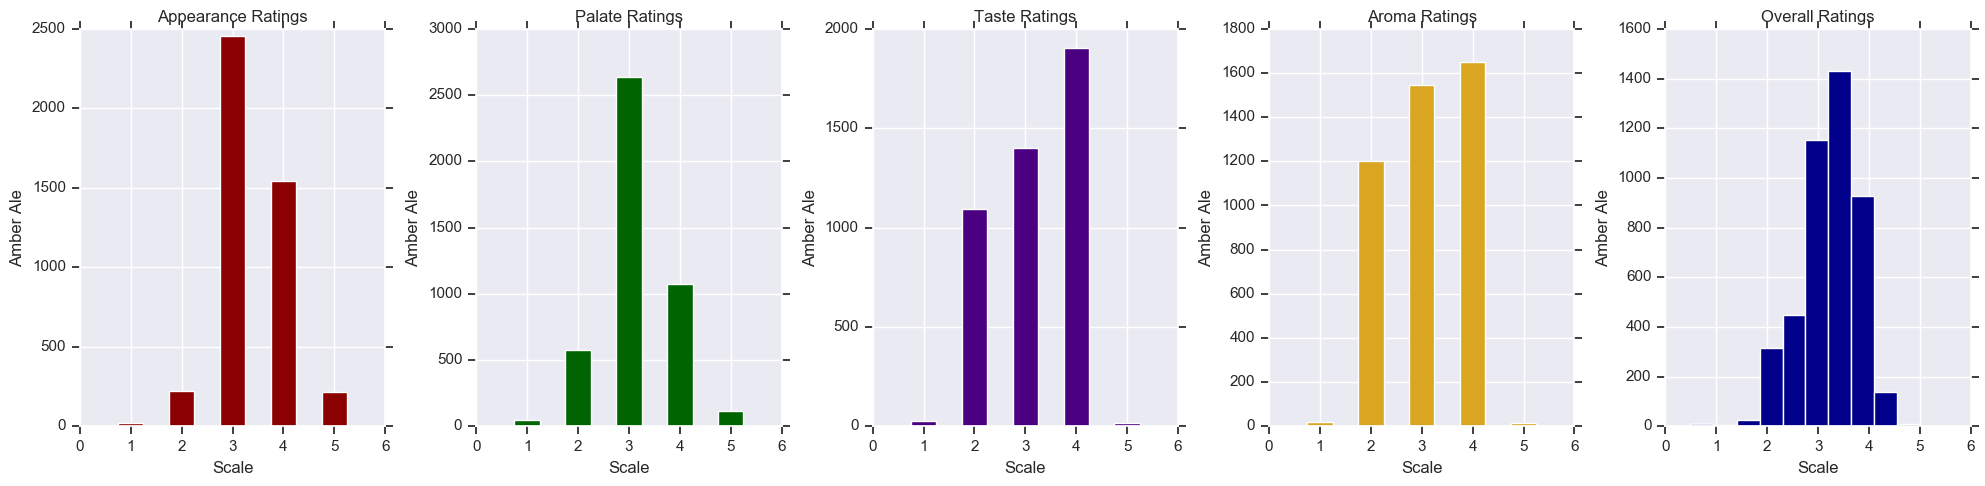

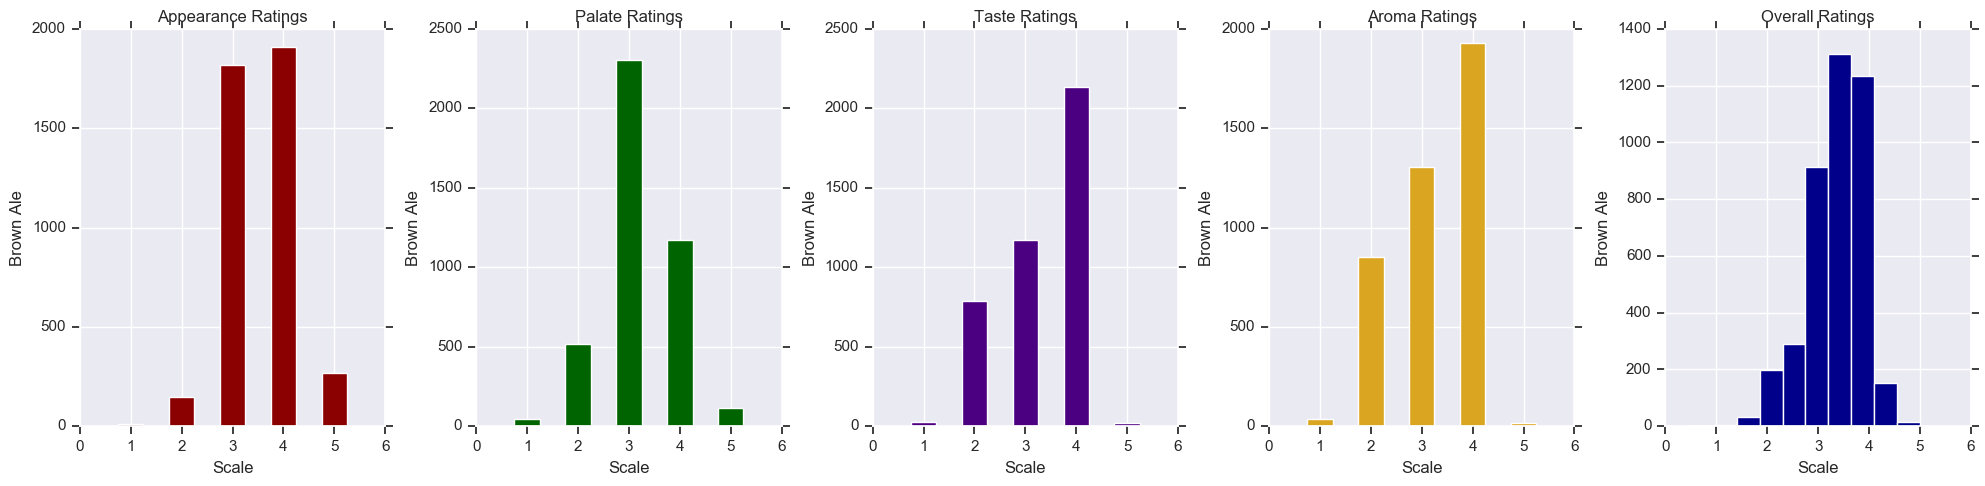

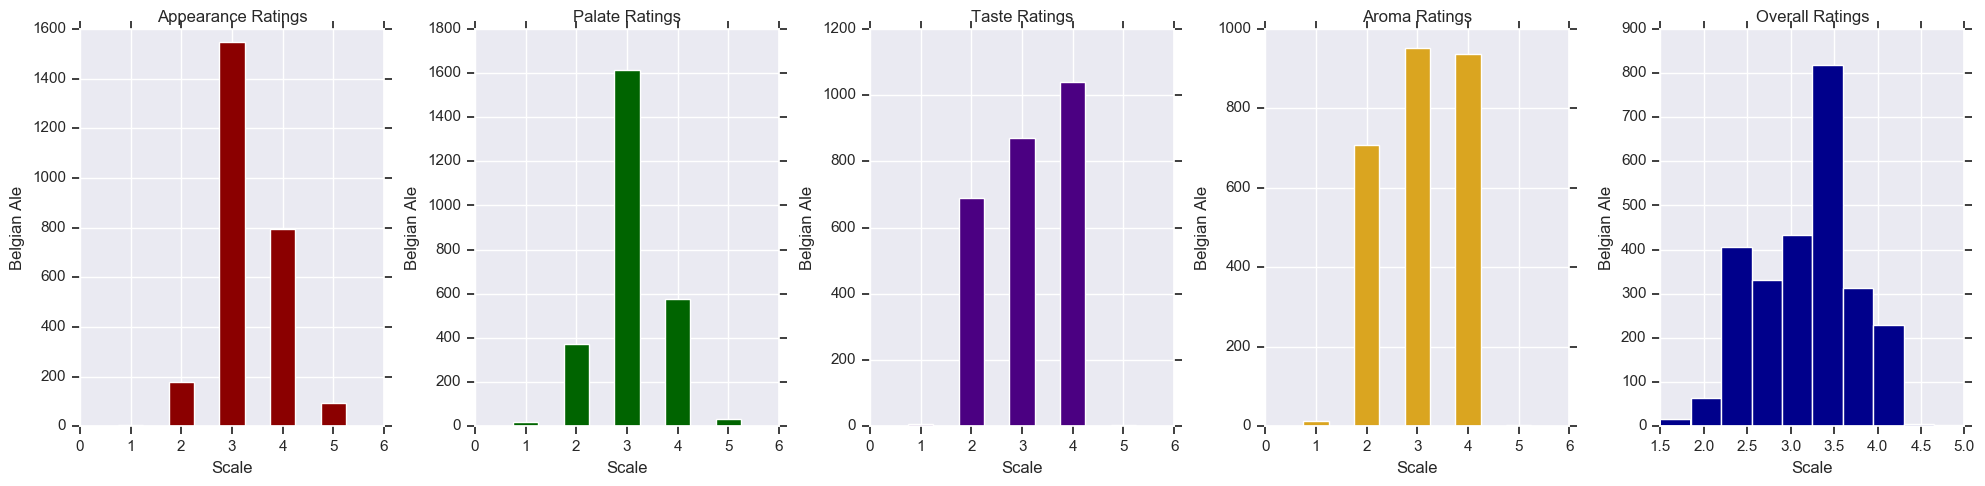

In [16]:
sns.set()

for b in beers:
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(151)
    plt.bar(range(1,6), np.bincount(beersmall[beersmall['style'] == b]['appearance'].values)[1:], width=0.5, 
            align='center', color='darkred')
    plt.xlabel('Scale')
    plt.ylabel(b)
    plt.title('Appearance Ratings')
   
    plt.subplot(152)
    plt.bar(range(1,6), np.bincount(beersmall[beersmall['style'] == b]['palate'].values)[1:], width=0.5, 
            align='center', color='darkgreen')
    plt.xlabel('Scale')
    plt.ylabel(b)
    plt.title('Palate Ratings')
    
    plt.subplot(153)
    plt.bar(range(1,6), np.bincount(beersmall[beersmall['style'] == b]['taste'].values)[1:], width=0.5, 
            align='center', color='indigo')
    plt.xlabel('Scale')
    plt.ylabel(b)
    plt.title('Taste Ratings')
    
    plt.subplot(154)
    plt.bar(range(1,6), np.bincount(beersmall[beersmall['style'] == b]['aroma'].values)[1:], width=0.5, 
            align='center', color='goldenrod')
    plt.xlabel('Scale')
    plt.ylabel(b)
    plt.title('Aroma Ratings')
    
    plt.subplot(155)
    plt.hist(beersmall[beersmall['style'] == b].overall, color='darkblue')
    plt.xlabel('Scale')
    plt.ylabel(b)
    plt.title('Overall Ratings')
    
    plt.tight_layout()
    plt.show()

Appearance Notes
+ majority fall between 3 and 4
+ 3 highest rating for belgian, amber, hef
+ 4 highest rating for IPA, porter, brown but not by much more than 3
+ 4 highest rating for Stout

#### Aroma

Notes
+ 4 highest overall for all ratings, except belgian(3 slightly higher)

#### Palate

Notes
+ 3 highest rating for all styles of beer

#### Taste

Notes
+ 4 highest rating overall for all styles of beer

#### Overall

Notes:
+ Overall most beer reviews fall between 3-4 rating for all beer styles


Appearance, Aroma, Taste - Highest rating is 4
Palate - Highest rating is 3

Most people are giving ratings of 3 and 4.
+ 1 never exceeds past 50 reviews in all.
+ 2 never exceeds past 1000 reviews
+ 5 never exceeds 500 reviews

Most users are giving ratings between 3 and 4 stars. 
Most beers are getting ratings between 3 and 4 stars.

It appears that very little to almost no bad reviews were given for the IPA beers in this selection. Every review gave at least a 1 star rating and for the most part 4 star ratings were given the highest. There were some 5 star ratings but not a lot.

Comparing the correlation between the different ratings, it appears that they were highly correlated amongst each other. The lowest correlation was between palate and taste ratings at .67, while the highest was almost 1 at .99 between taste and aroma. This makes sense because often times items taste as good as they smell. 

### Text Reviews
Next lets explore our text reviews to see if we can find anything interesting here.

#### 1. Number of Reviews per Beer

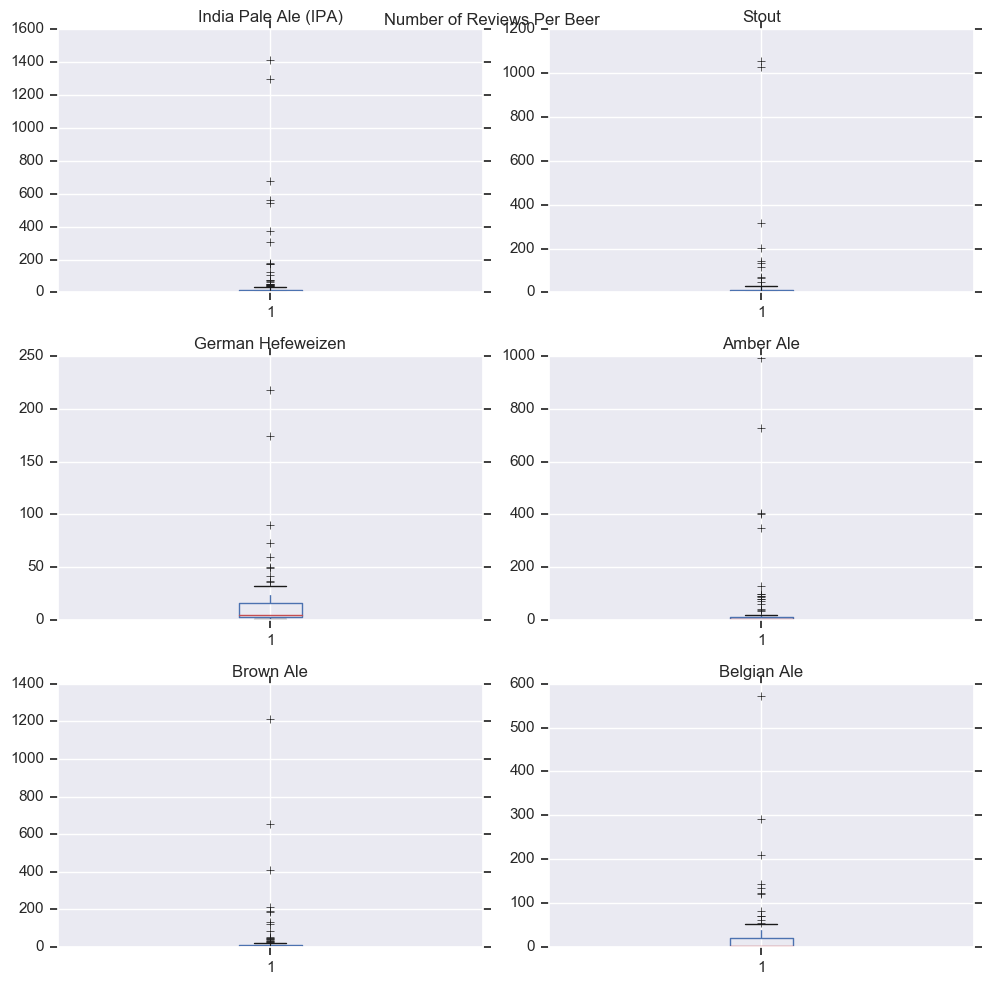

In [17]:
beer_counts(col="name", t="Number of Reviews Per Beer")

There are 231 different IPAs within this dataset. Out of these 231, 12 have over 100 reviews. 
Also, 212 beers have less than 50 reviews.

Now lets look at the average rating per beer between the various scale ratings. 

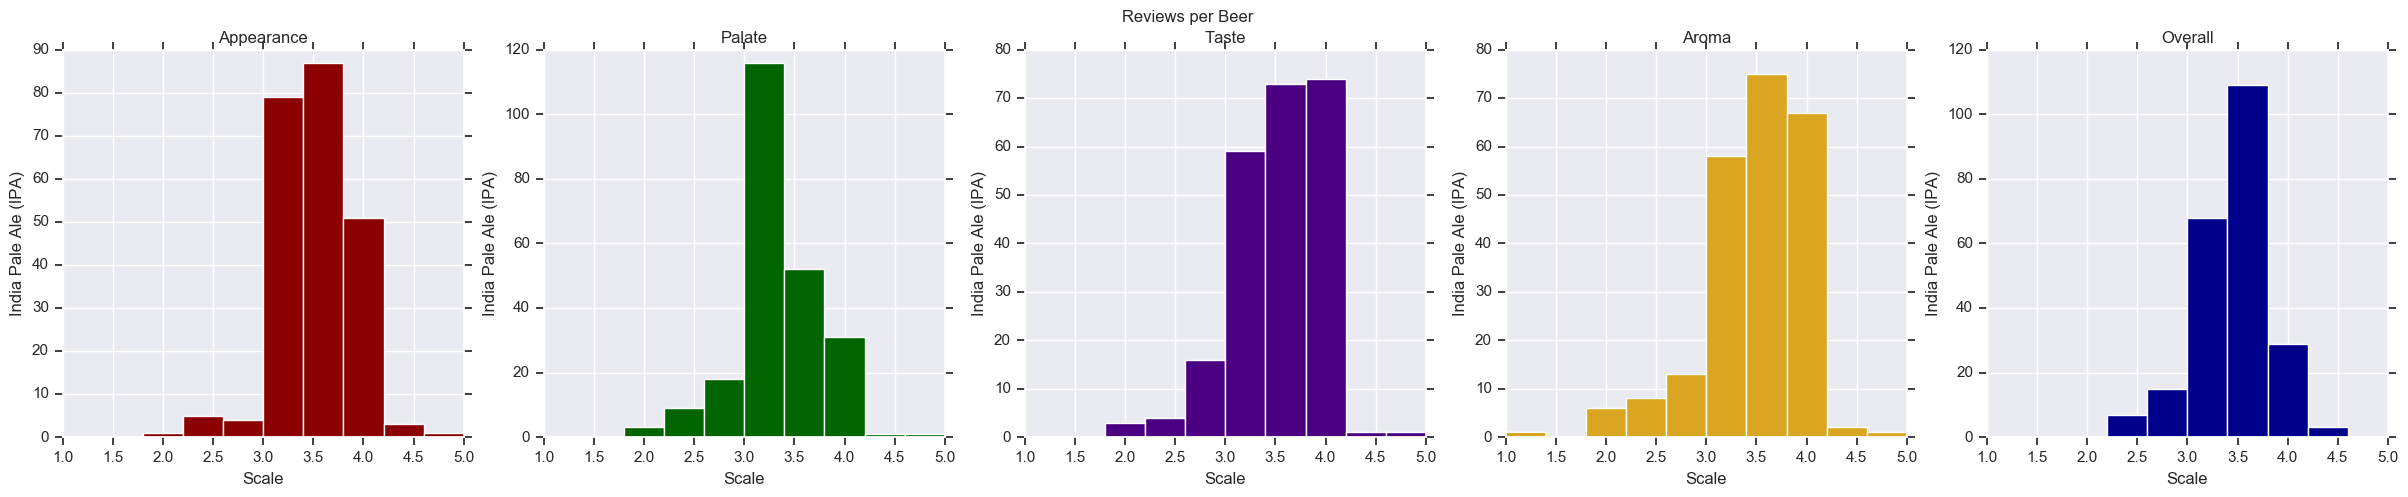

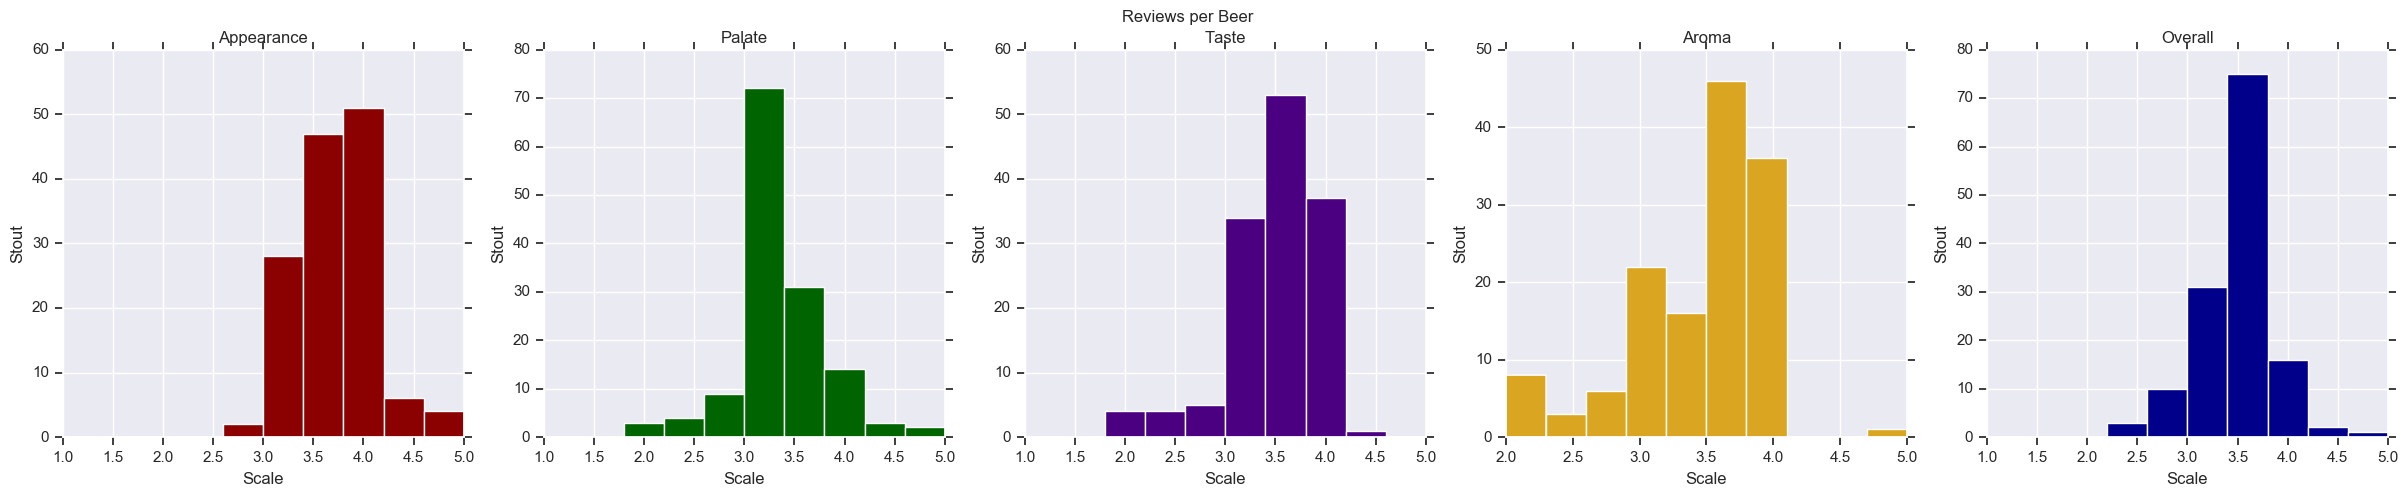

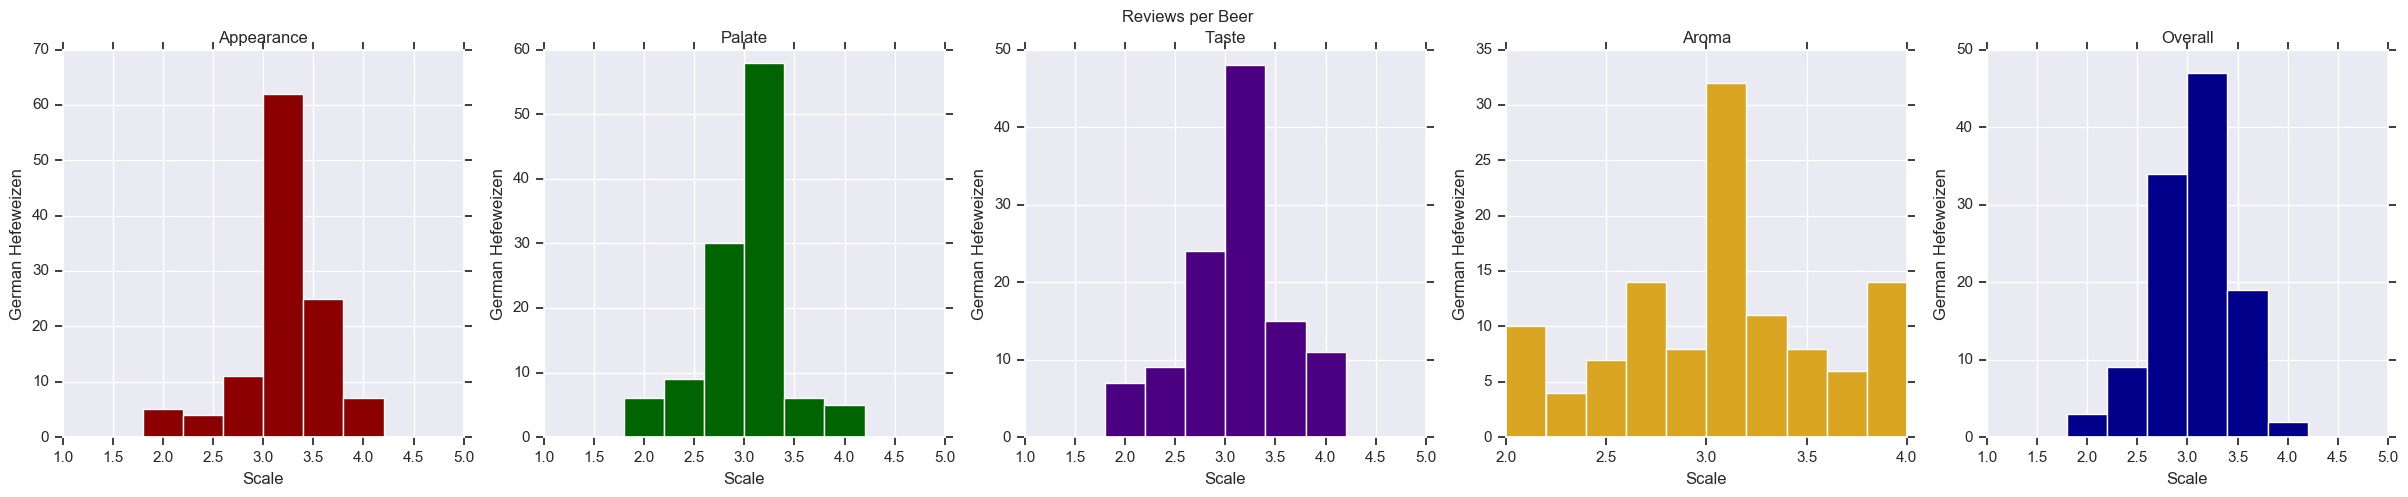

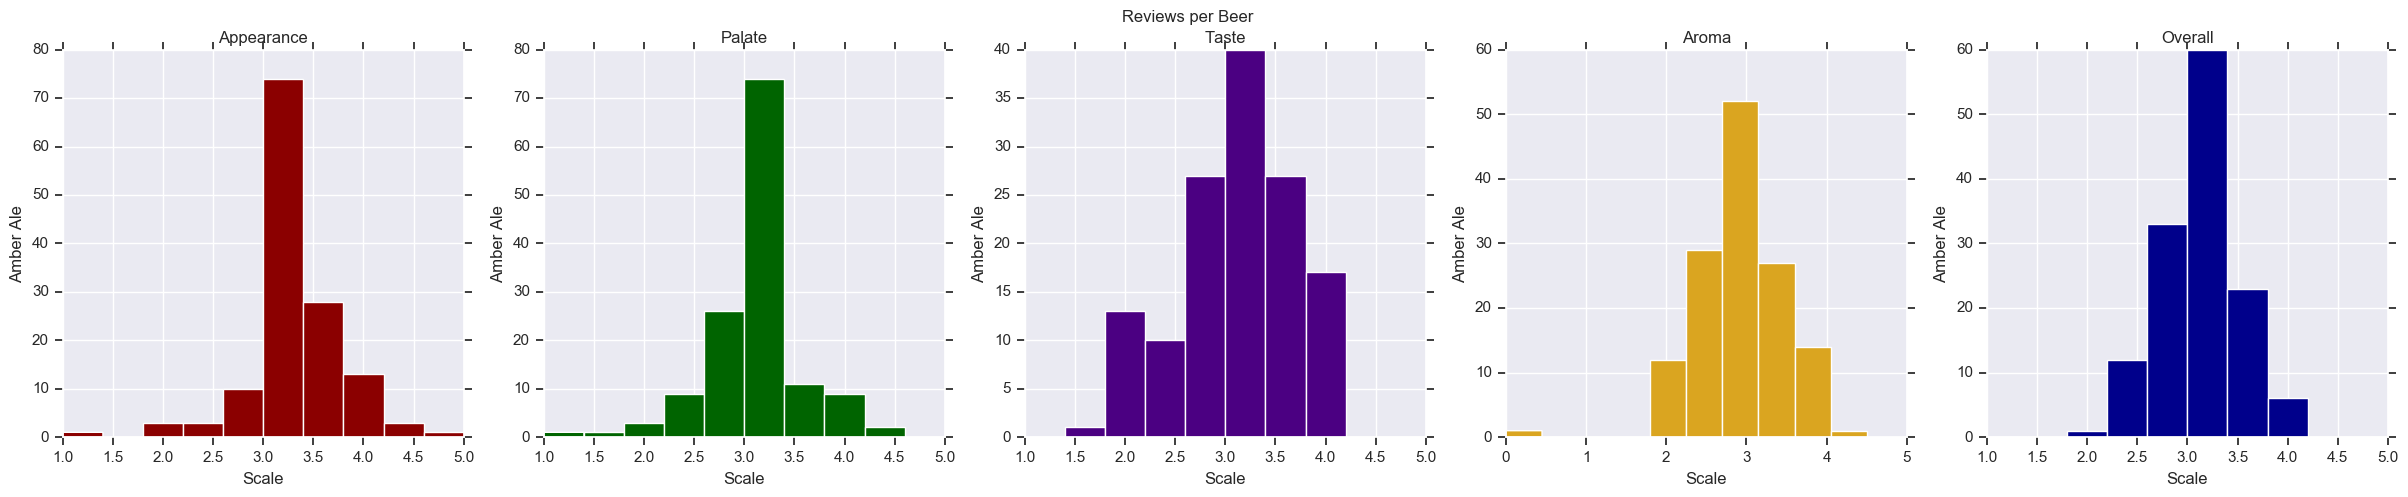

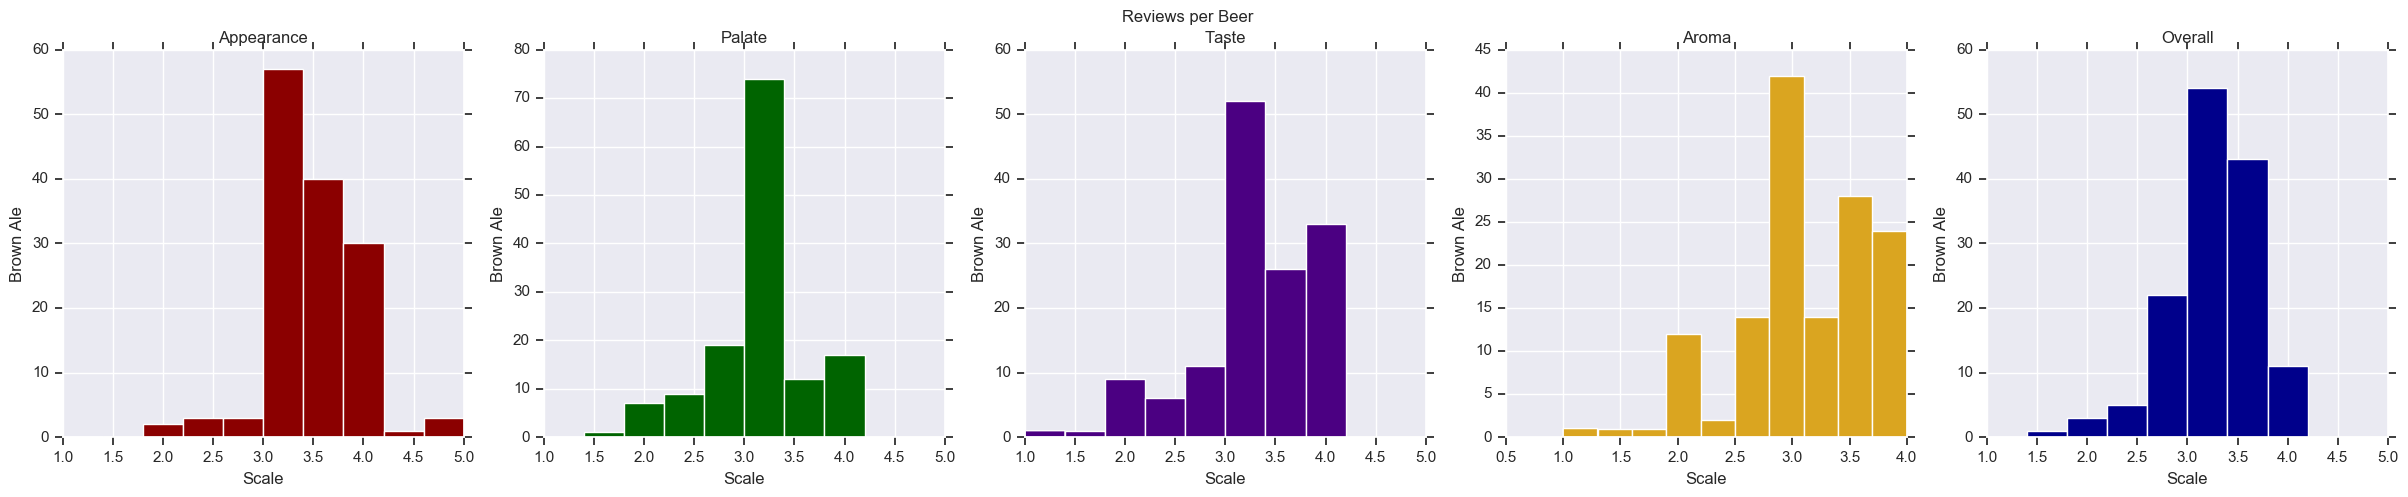

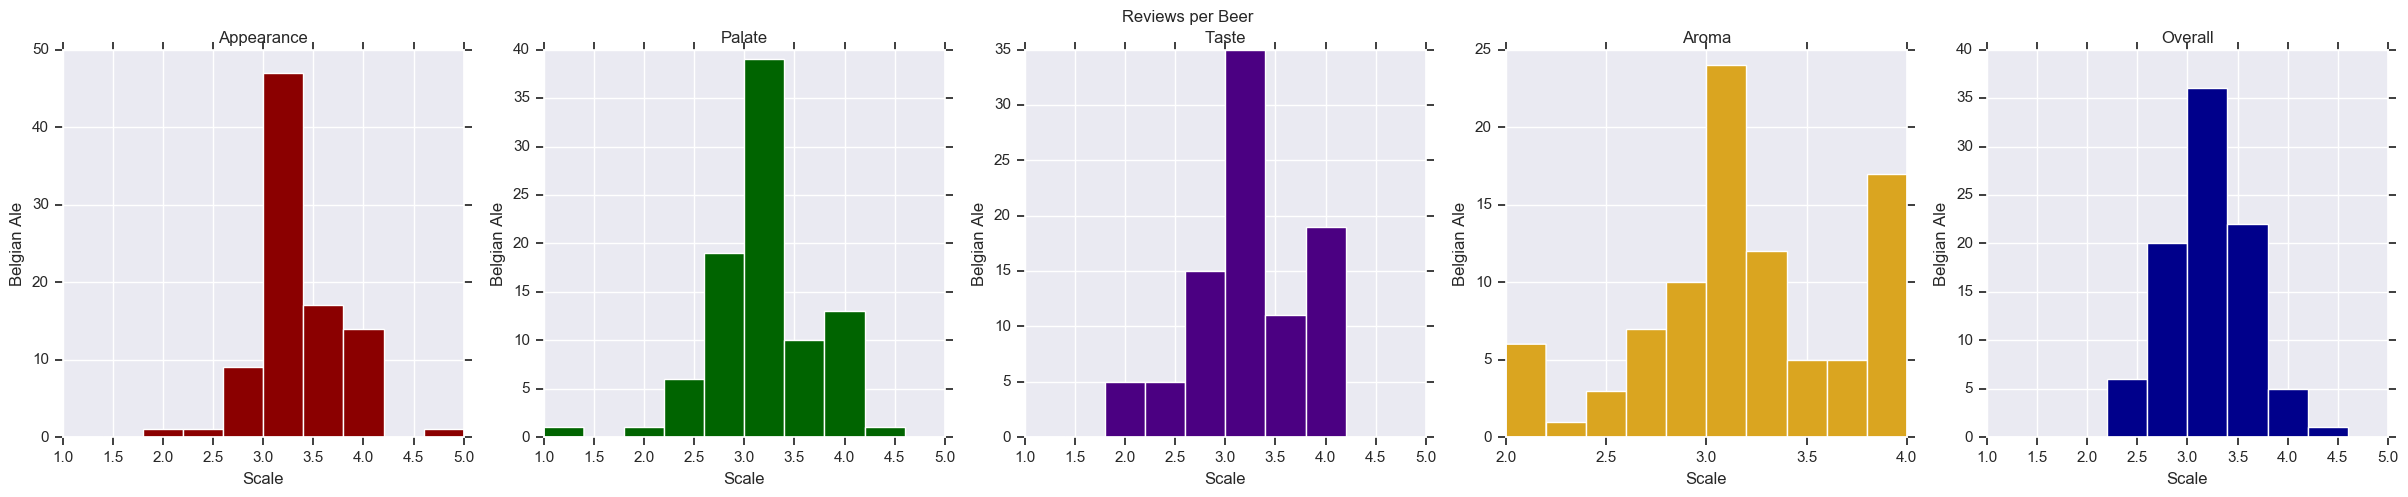

In [18]:
hist_rating_beer(col="name")

Looking at the histogram you see that the majority of beers have less than reviews. Diving deeper there are specifically 7 IPAs that have over 200 reviews. Lagunitas IPA being the highest at 1414 reviews. 

Again, you see that the majority of ratings fall between 3 to 4 on the scale rating system across all 5 scales. 

#### 2. Number of Reviews Per Reviewer

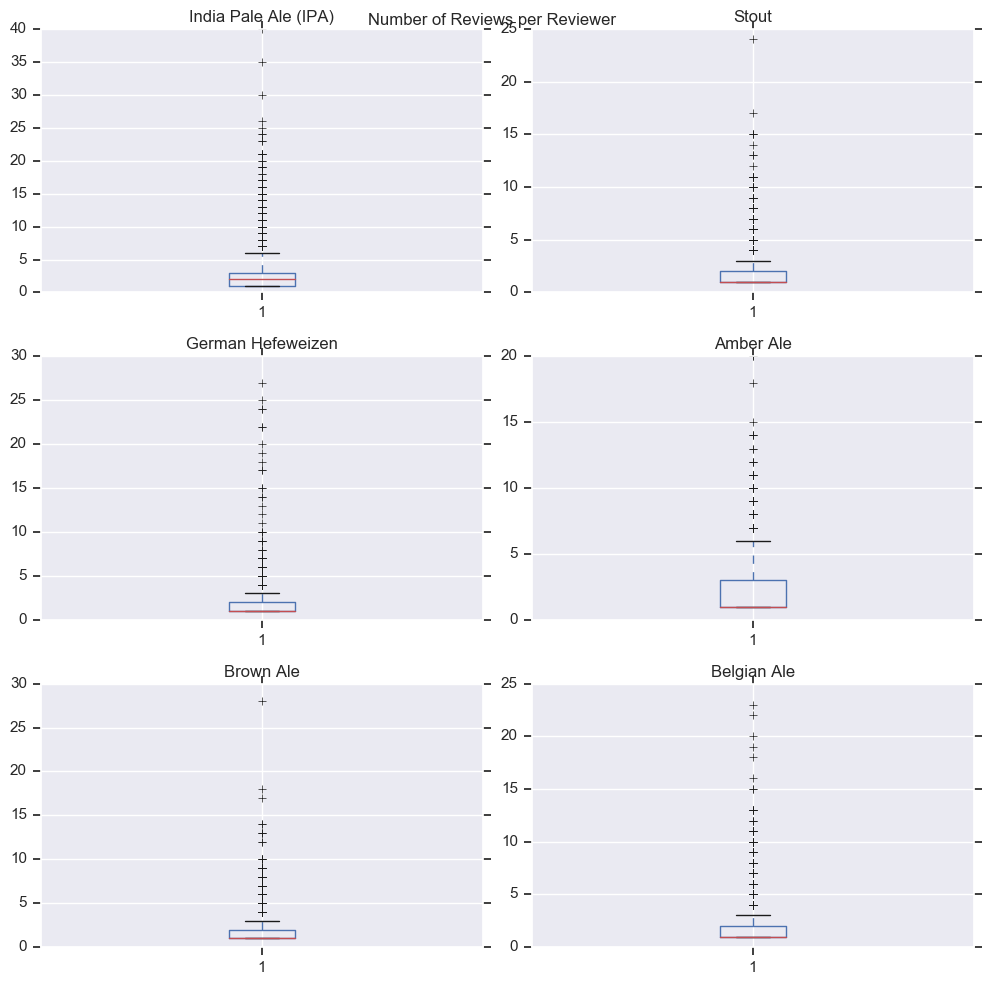

In [19]:
beer_counts(col="profileName", t="Number of Reviews per Reviewer")

Looking at the the data you notice that the majority of reviewers left only one review at 1280 out of the grand total of 2808 reviewers. This makes sense because you are going to have an avid group of people who consistently write reviews and interact on the site, but for the most part people will leave one or two reviews from time to time. Let's visualize this data to see what it looks like

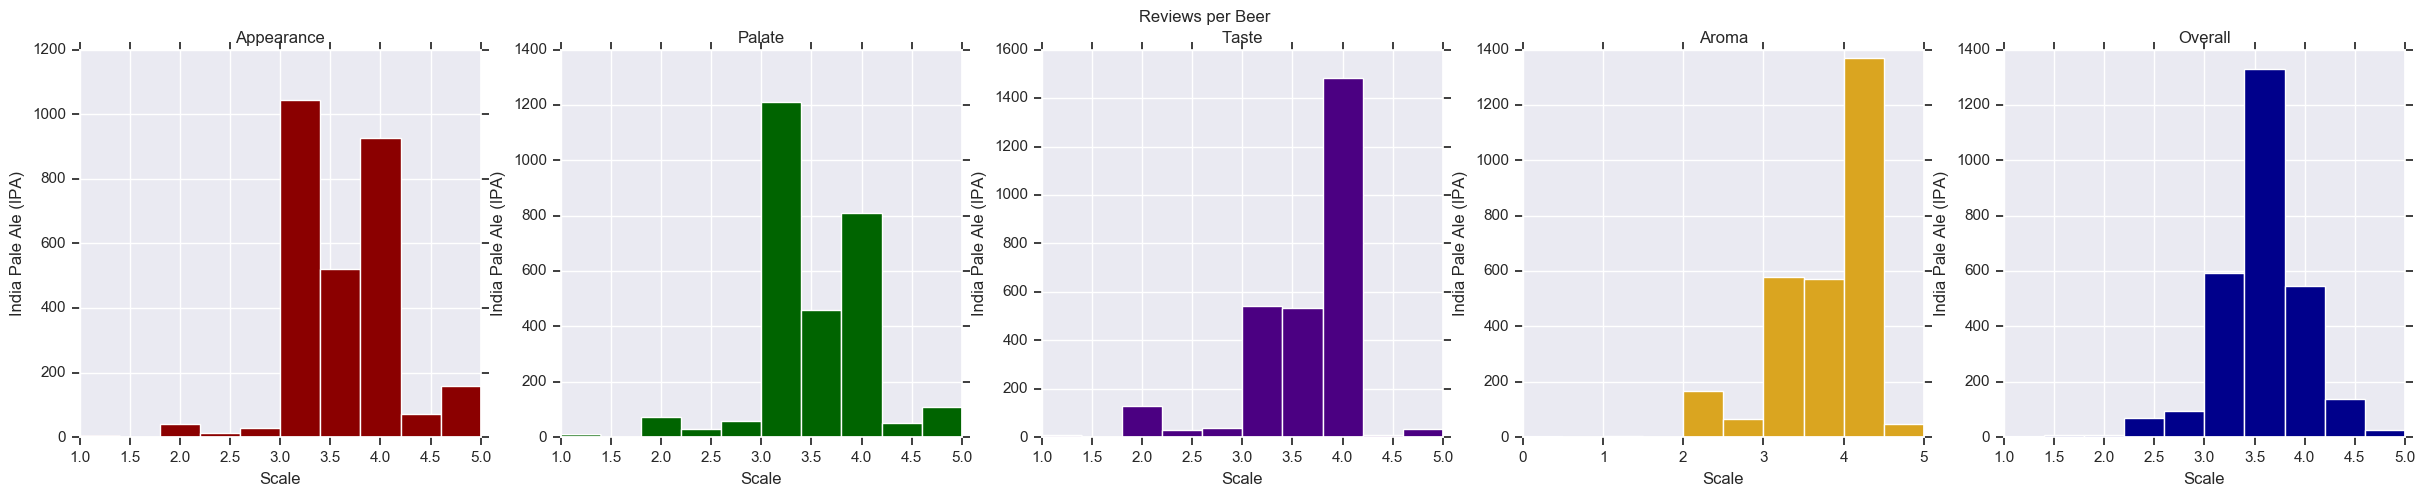

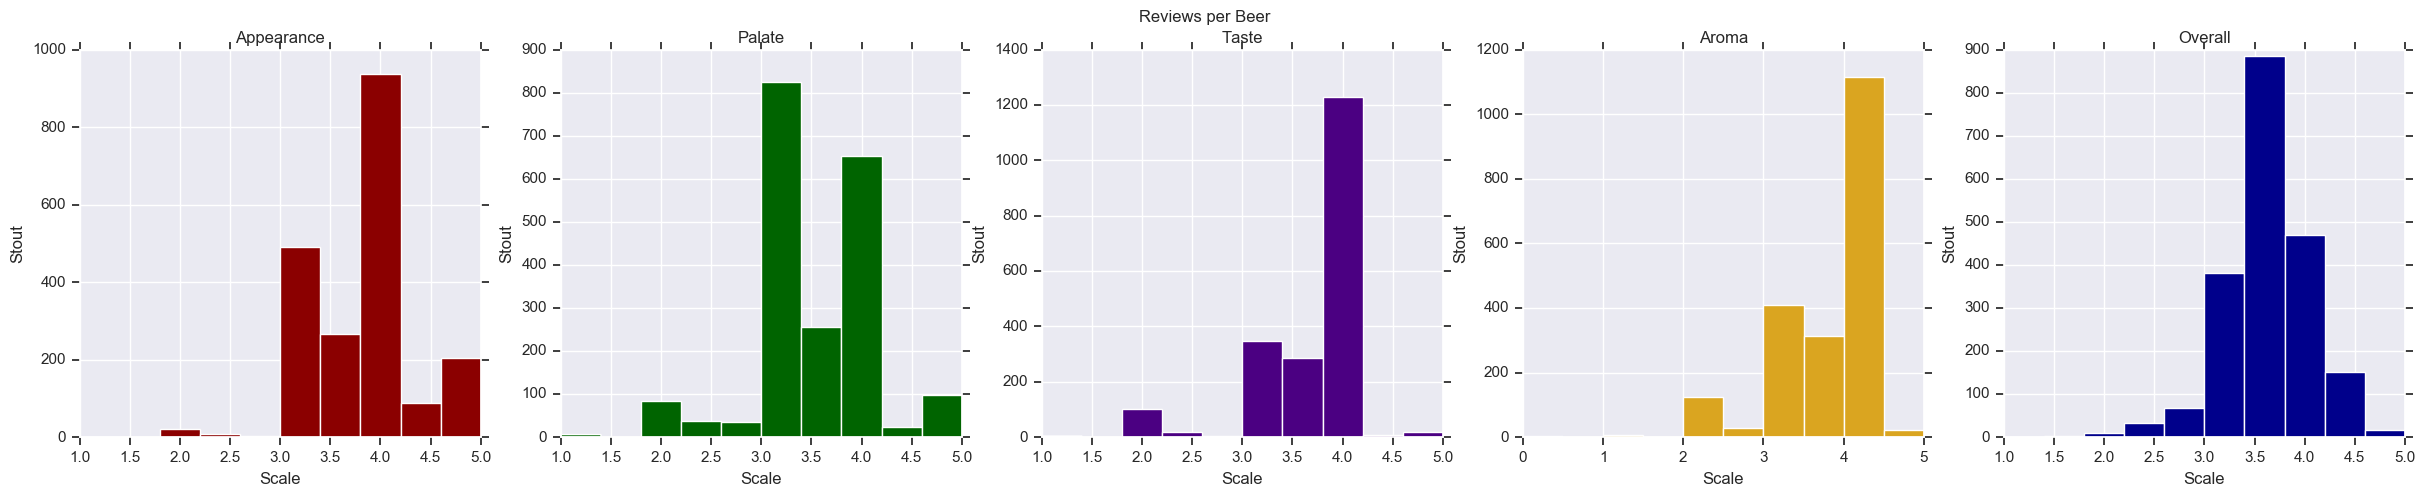

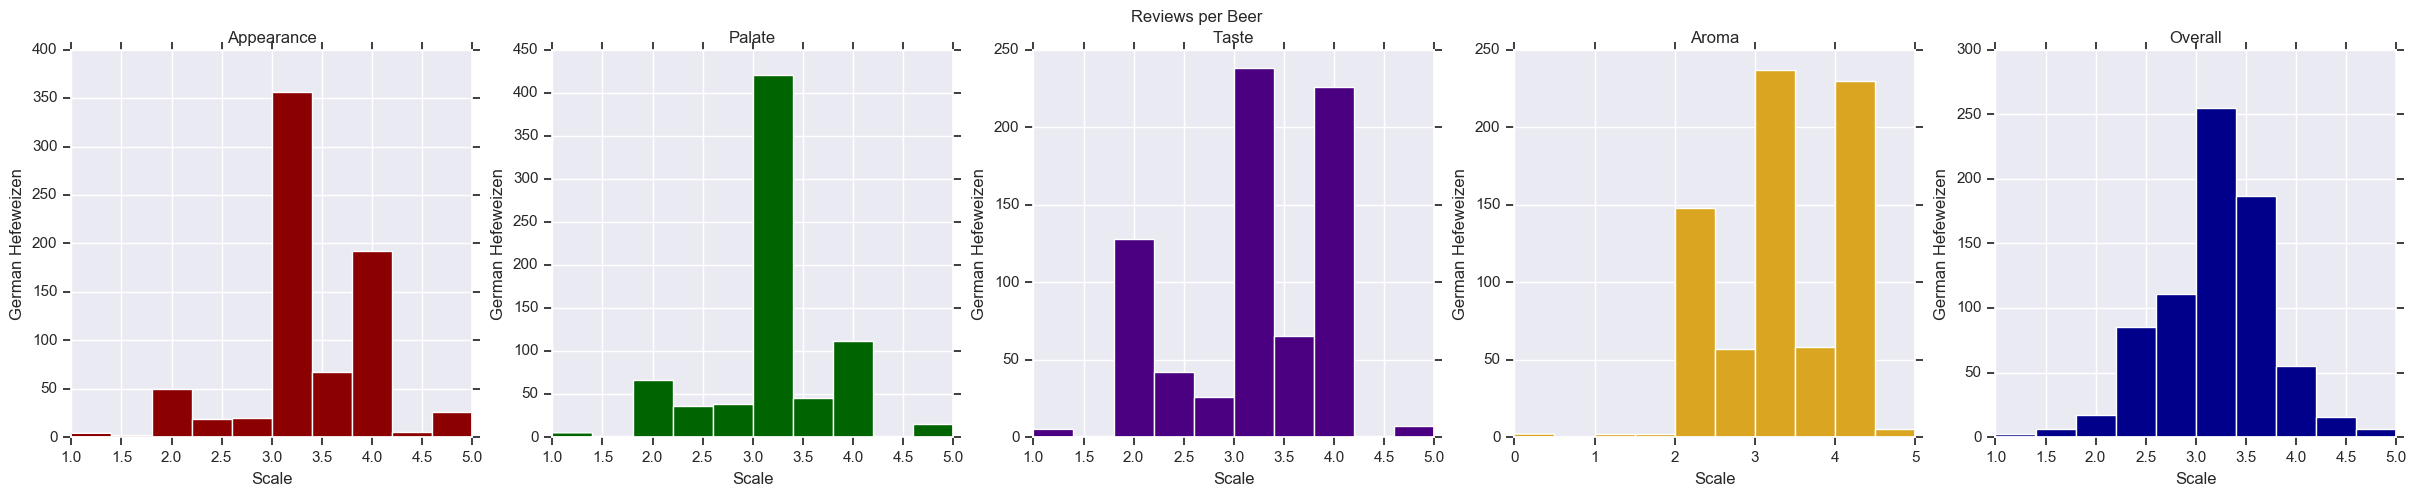

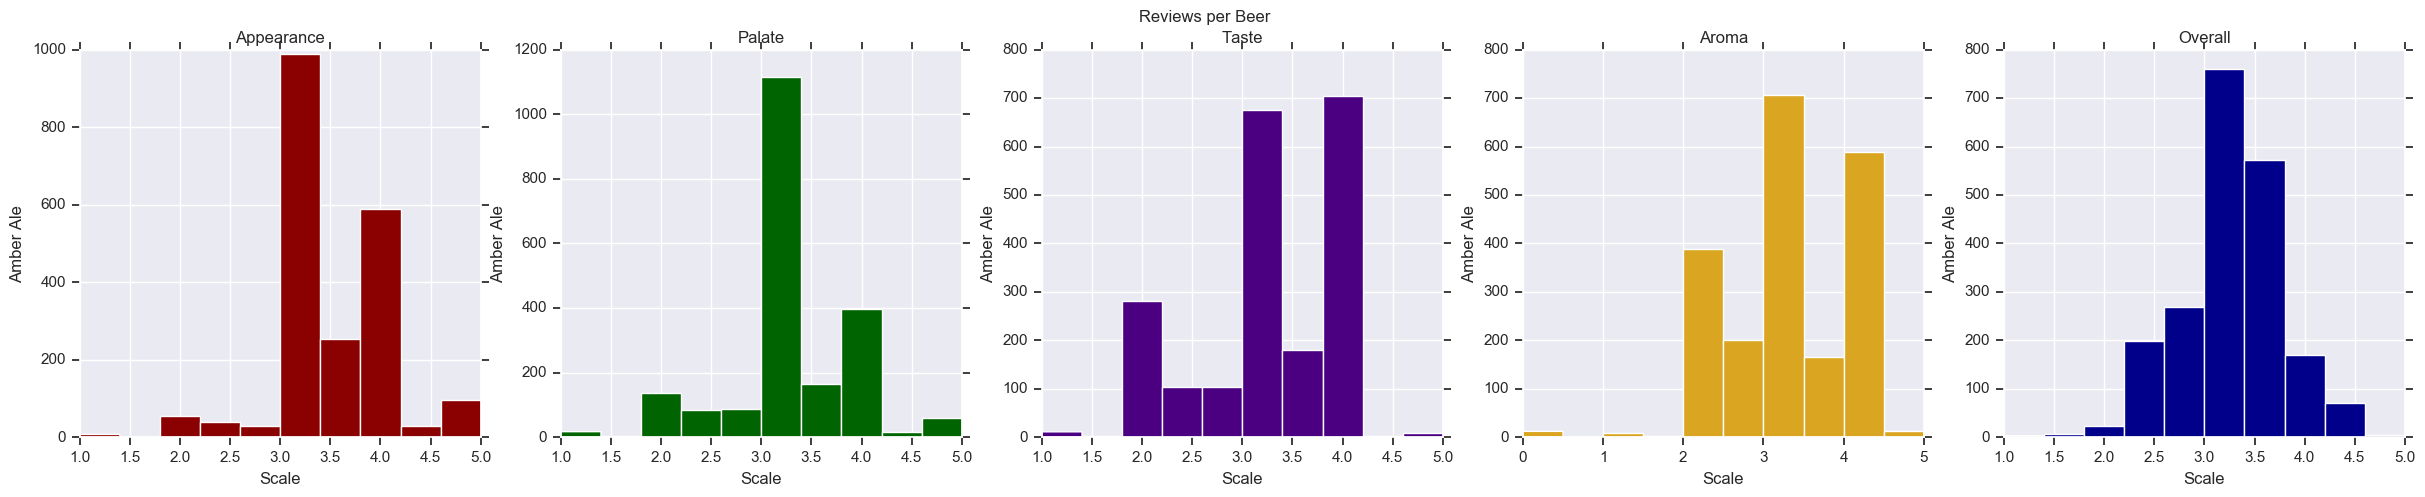

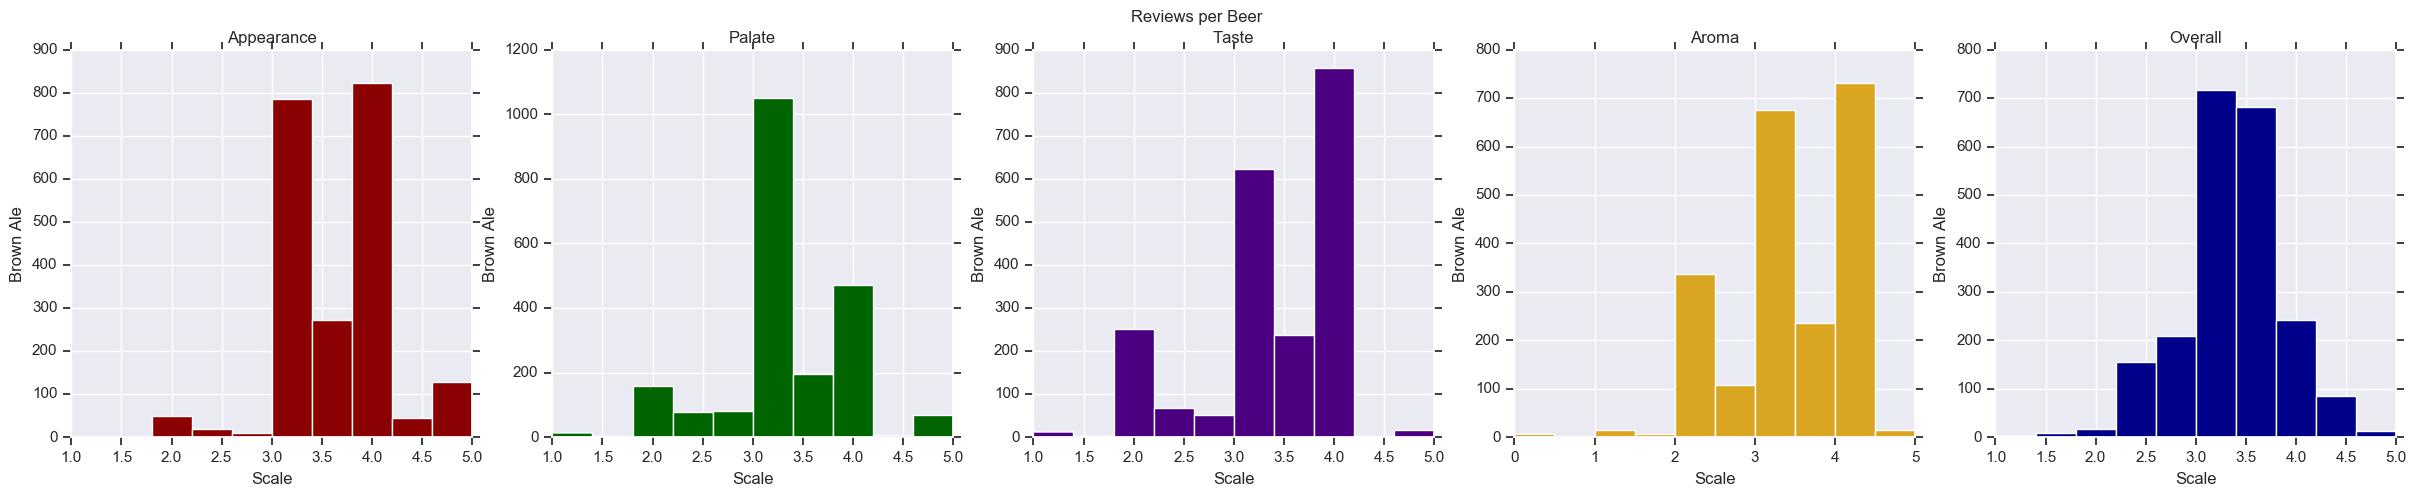

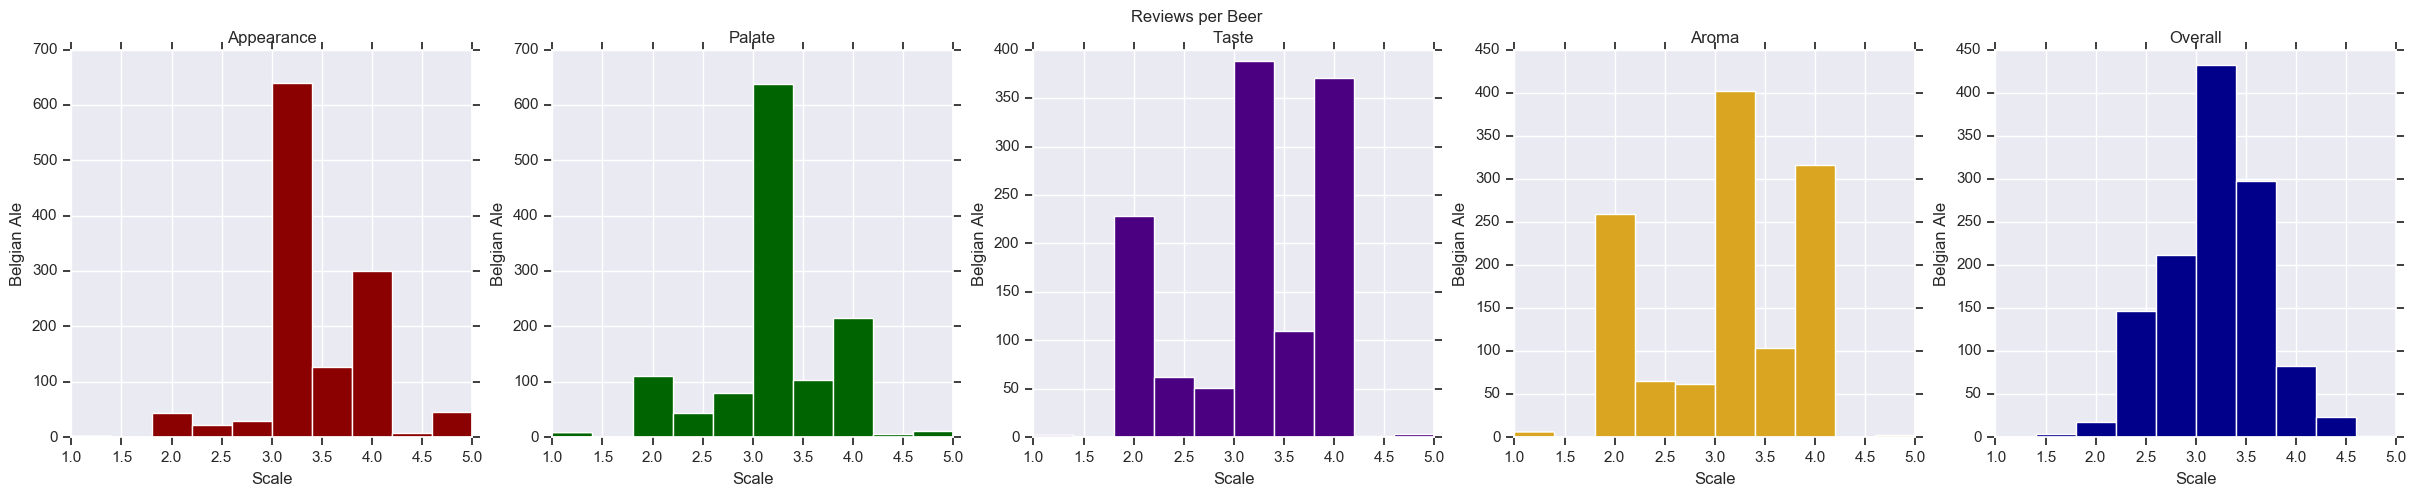

In [20]:
hist_rating_beer(col="profileName")

## Word Count

In [21]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.hist(ipa.word_count)
plt.title('Word Count')
plt.ylabel('Frequency')
plt.xlabel('Number of Words')

plt.subplot(122)
plt.hist(np.log(ipa.word_count))
plt.title('Word Count(Log)')
plt.ylabel('Frequency')
plt.xlabel('Number of Words')
plt.show()

NameError: name 'ipa' is not defined

The number of words per review is skewed to the right. This, however, is expected as people typically do not write essays when leaving reviews. The majority of reviews are 100 words or less with a few exceptions that may be possible outliers. This will have to be broken down further. 

When comparing the "overall rating" to the "word count per review" you see that the increased number of words per review appear more as the overall rating increases. 

Let's break this down further by looking at a breakdown of "low" and "high" reviews. We will determine this by using 3.75 as our middle marker from the overall ratings column.

### Low vs. High Ratings

In [ ]:
low = ipa[ipa.overall < 3.75]
high = ipa[ipa.overall >= 3.75]

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(221)
plt.hist(high.word_count, bins=75)
plt.title('High Word Count Hist')
plt.ylabel('Frequency')
plt.xlabel('Number of Words')

plt.subplot(222)
plt.hist(low.word_count, bins=75)
plt.title('Low Word Count Hist')
plt.ylabel('Frequency')
plt.xlabel('Number of Words')

plt.subplot(223)
plt.hist(np.log(high.word_count), bins=75)
plt.title('High Word Count Hist(Log)')
plt.ylabel('Frequency')
plt.xlabel('Number of Words')

plt.subplot(224)
plt.hist(np.log(low.word_count), bins=75)
plt.title('Low Word Count Hist(Log)')
plt.ylabel('Frequency')
plt.xlabel('Number of Words')

plt.tight_layout()
plt.show()

There doesn't appear to be a great difference between low vs. high ratings for word count. 

## Conclusion
From the Explorotary Analysis we can come up with some points:
+ Reviews per beer range from 6-1414 with an average of 77 reviews per beer. We must check for outliers for this.
+ Ratings on average appear to be around the 3.75 overall rating mark with the majority of reviewers providing 4 star feedback amongst the various rating categories
+ There are 7818 reviews from 101 different IPAs, reviewed by 2808 different reviewers
+ The largest review has 529 words while the smallest has 3 words. The average is roughly 55 words. 
+ The average character count is roughly 310 characters.



## Sources
***
Lipton, Zachary & Vikram, Sharad & McAuley, Julian. (2015). Capturing Meaning in Product Reviews with Character-Level Generative Text Models.
https://www.researchgate.net/publication/283761921_Capturing_Meaning_in_Product_Reviews_with_Character-Level_Generative_Text_Models